# Case Study 6.1 - NYC Taxi Trips

# ADVANCED PYTHON

As this is an advanced version, we don't include a lot of code here. If you get stuck on a particular part, feel free to also use the beginner version in `beginnner_python.ipynb` to help you out.

If you don't know your MITx username, you can create a test post [here](https://courses.xpro.mit.edu/courses/course-v1:xPRO+DSx+R11/discussion/forum/general/threads/5db91a5c59a54c4eb6000031) to find it.

# Identification Information

In [1]:
# YOUR NAME              = Manuel Montoya
# YOUR MITX PRO USERNAME = manuel-montoya-gamio
# YOUR MITX PRO E-MAIL   = manuel.montoya@pucp.edu.pe

# Setup

Run these cells to install all the packages you need to complete the remainder of the case study. This may take a few minutes, so please be patient.

In [2]:
# !pip install --upgrade pip
# !pip install featuretools==0.1.19
# !pip install pandas==0.20.3

# Import

In [3]:
import featuretools as ft
import matplotlib
import numpy as np
import pandas as pd
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)
import seaborn

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [6]:
%matplotlib inline

In [7]:
#Checking for correct packages versiones

print("pandas: ", pd.__version__)
print("featuretools: ", ft.__version__)

pandas:  0.20.3
featuretools:  0.1.19


# Data

- Use `load_nyc_taxi_data` to get the data.
- Use `preview` to preview the data.
- Create a histogram of the `trip_duration` column of the `trips` table.

In [8]:
# Your code here to load, preview and visualize data
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()

In [9]:
#complete trips for taxis, pickpup and dropoff are defined as (longitude, latitude) pairs
preview(trips, 5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


In [10]:
#mapping of latitude, longitude to neiborhood_ids for pickup neiborhoods
preview(pickup_neighborhoods, 5)

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


In [11]:
#mapping of latitude, longitude to neiborhood_ids for dropoff neiborhoods
preview(dropoff_neighborhoods, 5)

,neighborhood_id,latitude,longitude
0,C,40.783780,-73.953145
1,S,40.836792,-73.934381
2,AL,40.818445,-73.948046
3,J,40.799573,-73.940427
4,AV,40.776270,-73.982322


*Some information about the datasets*

In [12]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
id                      10000 non-null int64
vendor_id               10000 non-null int64
pickup_datetime         10000 non-null datetime64[ns]
dropoff_datetime        10000 non-null datetime64[ns]
passenger_count         10000 non-null int64
trip_distance           10000 non-null float64
pickup_longitude        10000 non-null float64
pickup_latitude         10000 non-null float64
dropoff_longitude       10000 non-null float64
dropoff_latitude        10000 non-null float64
payment_type            10000 non-null object
trip_duration           10000 non-null int64
pickup_neighborhood     9816 non-null object
dropoff_neighborhood    9835 non-null object
dtypes: datetime64[ns](2), float64(5), int64(4), object(3)
memory usage: 1.5+ MB


In [13]:
pickup_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
neighborhood_id    49 non-null object
latitude           50 non-null float64
longitude          50 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


In [14]:
dropoff_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
neighborhood_id    49 non-null object
latitude           50 non-null float64
longitude          50 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


There are some null values for some locations in the trips dataset

## Where are the null values for pickup and dropoff neighborhood?

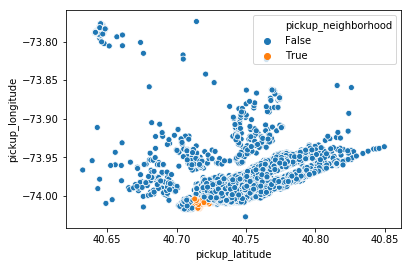

In [15]:
seaborn.scatterplot(trips["pickup_latitude"], trips["pickup_longitude"], hue = trips["pickup_neighborhood"].isnull())

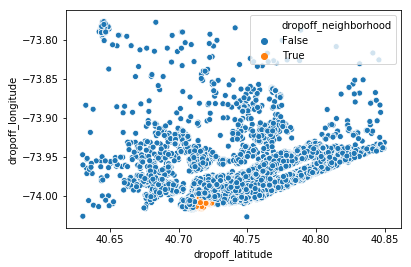

In [16]:
seaborn.scatterplot(trips["dropoff_latitude"], trips["dropoff_longitude"], hue = trips["dropoff_neighborhood"].isnull())

As the graphics show, the null values for neiborhood ids are located around the same location on latitude and longitude for pickup and dropoff.

**Making a couple of histograms for the trip durations on count and distributions**

In [17]:
trips["trip_duration"].describe()

count    10000.000000
mean       746.098900
std        525.049496
min          2.000000
25%        364.000000
50%        616.000000
75%        988.000000
max       3573.000000
Name: trip_duration, dtype: float64

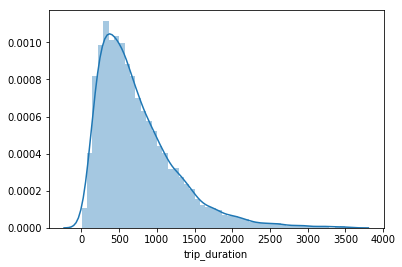

In [18]:
seaborn.distplot(trips["trip_duration"])

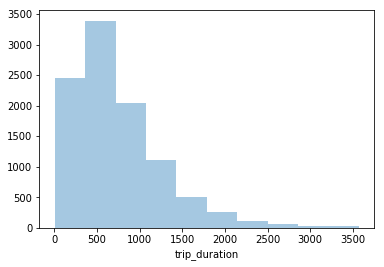

In [19]:
seaborn.distplot(trips["trip_duration"], kde= False, bins = 10)

Next, we want to check the day distribution of the trips to see if there is some variation across them

First, let's check which days appear on the dataset on both dropoff and pickup datetimes

In [20]:
get_weekday = lambda datetime: datetime.strftime('%A')

trips["pickup_datetime"].apply(get_weekday).unique(), trips["dropoff_datetime"].apply(get_weekday).unique()

(array(['Saturday', 'Sunday'], dtype=object),
 array(['Saturday', 'Sunday'], dtype=object))

Surprisingly there are only Saturday and Sunday trips on the dataset

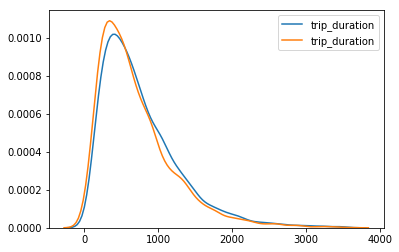

In [21]:
saturday_trips = trips.loc[trips["pickup_datetime"].apply(get_weekday) == "Saturday"]
sunday_trips = trips.loc[trips["pickup_datetime"].apply(get_weekday) == "Sunday"]

seaborn.kdeplot(saturday_trips["trip_duration"])
seaborn.kdeplot(sunday_trips["trip_duration"])

Both days have very similar distributions so apparently between weekend days there is not much variation on trip duration.

<h1 style="color: black;">QUESTION 1: DATA ANALYSIS</h1>

**Describe the dataset. How many trips are in the dataset? How would you describe the distribution of trip durations? Is there anything else we should observe? Make sure the histogram is visible in the notebook.**

The dataset is divided into three tables. 
* **Trips**: Contains details about each trip, the number of passengers, pickup and dropoff locations in latitude and longitude and more.
* **Pickup neighborhoods**: Contains indicators of neighborhoods for each pickup location (latitude, longitude)
* **Dropoff neighborhoods**: Contains indicators of neighborhoods for each dropoff location (latitude, longitude) 

There are ten thousend trips in the dataset, most of them have complete records, except for about two hundred that don't have an identified neighborhood. As the scatter plots show, these are concentrated around the same location, which indicates that maybe the data recollection on neighborhoods is not complete.

There is only weekend trips on the dataset, which could result in some biased results for prediction in time duration for all weekdays.

The distribution of the duration of the trips is skewed with a long right tail. The mean of the trips is 750 seconds long, which is about 12 minutes, which seems appropiate.

# Entities and Relationships

Construct a dictionary of entities and relationships. You can read about the format of these objects [`here`](https://docs.featuretools.com/en/stable/generated/featuretools.dfs.html).

In [22]:
# Construct entities and relationships dicts

entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

# Transform Primitives

In [23]:
# Make list of transform primtivies that only contains the Weekend object from above
trans_primitives = [Weekend]

In [24]:
# Then, use featuretools.dfs to get the features
# See https://docs.featuretools.com/generated/featuretools.dfs.html
# target entity should match name for trips entity in your entities dictionary
# no agg_primitives yet
# ignore the lat/long for dropoff and pickup

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

In [25]:
# Print out the features you just made
len(features), features

(12,
 [<Feature: vendor_id>,
  <Feature: passenger_count>,
  <Feature: trip_distance>,
  <Feature: payment_type>,
  <Feature: pickup_neighborhood>,
  <Feature: dropoff_neighborhood>,
  <Feature: IS_WEEKEND(pickup_datetime)>,
  <Feature: IS_WEEKEND(dropoff_datetime)>,
  <Feature: pickup_neighborhoods.latitude>,
  <Feature: pickup_neighborhoods.longitude>,
  <Feature: dropoff_neighborhoods.latitude>,
  <Feature: dropoff_neighborhoods.longitude>])

Feature tools will create two new features based on the original datetime columns for pickup and dropoff times

In [26]:
# Use compute_features to get the feature matrix from the list of features you just made
feature_matrix = compute_features(features)

Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


In [27]:
preview(feature_matrix, 5)

,trip_distance,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,...,dropoff_neighborhood = M,dropoff_neighborhood = AF,dropoff_neighborhood = T,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ,pickup_neighborhoods.longitude,IS_WEEKEND(dropoff_datetime),vendor_id
id,,,,,,,,,,,,,,,,,,,,,
514030,2.46,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-73.986446,True,2
514031,7.90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-73.919159,True,1
514032,1.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-73.991595,True,1
514033,0.02,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-73.987205,True,2
514034,19.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-73.785073,True,1


The function compute_features has also one hot encoded the pickup and dropoff neighborhoods

# First Model

In [28]:
# Split feature matrix (75% train, 25% test) using utils.train_test_fm
# Pass in features, trips dataframe, and fraction train (0.75)

X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)

In [29]:
# Use np.log(x + 1) to take the log of a particular vector x - this helps create a more linear relationship
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [30]:
# Then, create a GradientBoostingRegressor
# Fit to training
# Score on testing
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.4736           21.49s
         2           0.4148           21.23s
         3           0.3661           21.54s
         4           0.3266           21.54s
         5           0.2934           20.93s
         6           0.2665           20.57s
         7           0.2441           20.13s
         8           0.2257           19.61s
         9           0.2103           19.09s
        10           0.1973           18.58s
        20           0.1433           15.48s
        30           0.1308           13.04s
        40           0.1252           10.36s
        50           0.1212            8.03s
        60           0.1187            6.07s
        70           0.1167            4.38s
        80           0.1155            2.82s
        90           0.1143            1.37s
       100           0.1133            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [32]:
# R squared for train and test 

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

r2_train = r2_score(y_train, prediction_train)
r2_test = r2_score(y_test, prediction_test)

print(f"R2 train: {r2_train}")
print(f"R2 test: {r2_test}")

R2 train: 0.7922934827227895
R2 test: 0.755456069153074


<h1 style="color: black;">QUESTION 2: FIRST MODEL</h1>

**Describe all the features that we added to the model. Do you think these improved the performance from a model that did not have these features? Why?**

There were several features added by the preprocessing pipeline. 

* The pickup and dropoff neighborhood identificators were one hot encoded, that means that one categorical column was transformed into a long list of columns with flags that indicate if the trip started or ended at an specific neighborhood.

* The datetime objects were transformed into a binary flags that indicate wether the date was during a weekend or not. It seems logical that these will get a better performance since traffic should be lighter on weekends when most of the people is not working and including this flags helps us capture this information while training. However, as we noted previously, all the trips on the dataset occurred during weekends so the performance doesn't change if we include this column or not because the columns contain the same constant value on all rows.

# More Transform Primitives

In [33]:
# Make list of transform primtivies that contain new primitives described in the instruction manual

trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

In [34]:
# Compute features
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

len(features), features

(24,
 [<Feature: vendor_id>,
  <Feature: passenger_count>,
  <Feature: trip_distance>,
  <Feature: payment_type>,
  <Feature: pickup_neighborhood>,
  <Feature: dropoff_neighborhood>,
  <Feature: MINUTE(pickup_datetime)>,
  <Feature: MINUTE(dropoff_datetime)>,
  <Feature: HOUR(pickup_datetime)>,
  <Feature: HOUR(dropoff_datetime)>,
  <Feature: DAY(pickup_datetime)>,
  <Feature: DAY(dropoff_datetime)>,
  <Feature: WEEK(pickup_datetime)>,
  <Feature: WEEK(dropoff_datetime)>,
  <Feature: MONTH(pickup_datetime)>,
  <Feature: MONTH(dropoff_datetime)>,
  <Feature: WEEKDAY(pickup_datetime)>,
  <Feature: WEEKDAY(dropoff_datetime)>,
  <Feature: IS_WEEKEND(pickup_datetime)>,
  <Feature: IS_WEEKEND(dropoff_datetime)>,
  <Feature: pickup_neighborhoods.latitude>,
  <Feature: pickup_neighborhoods.longitude>,
  <Feature: dropoff_neighborhoods.latitude>,
  <Feature: dropoff_neighborhoods.longitude>])

In [35]:
# Compute feature matrix
feature_matrix = compute_features(features)
preview(feature_matrix, 5)

Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,IS_WEEKEND(dropoff_datetime),MINUTE(pickup_datetime),DAY(pickup_datetime),WEEK(pickup_datetime),pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,pickup_neighborhood = AD,...,WEEKDAY(pickup_datetime),HOUR(pickup_datetime),MINUTE(dropoff_datetime),HOUR(dropoff_datetime),pickup_neighborhoods.latitude,payment_type,IS_WEEKEND(pickup_datetime),passenger_count,WEEKDAY(dropoff_datetime),DAY(dropoff_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,True,0,2,13,1,0,0,0,0,0,...,5,0,17,0,40.757707,1,True,1,5,2
514031,True,0,2,13,0,0,0,0,0,0,...,5,0,24,0,40.744928,1,True,2,5,2
514032,True,0,2,13,0,0,0,0,0,0,...,5,0,19,0,40.729652,1,True,1,5,2
514033,True,0,2,13,0,0,1,0,0,0,...,5,0,1,0,40.720245,2,True,1,5,2
514034,True,1,2,13,0,0,0,0,0,0,...,5,0,58,0,40.646194,1,True,2,5,2


In [36]:
# Re-split feature matrix
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [37]:
# Train and score NEW model
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.4736           20.59s
         2           0.4148           21.66s
         3           0.3661           21.02s
         4           0.3264           20.89s
         5           0.2930           20.00s
         6           0.2660           19.66s
         7           0.2432           19.30s
         8           0.2245           18.95s
         9           0.2090           18.59s
        10           0.1960           18.42s
        20           0.1362           16.26s
        30           0.1198           13.71s
        40           0.1124           11.16s
        50           0.1075            8.78s
        60           0.1044            6.61s
        70           0.1017            4.73s
        80           0.0999            3.01s
        90           0.0971            1.45s
       100           0.0936            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [38]:
# R squared for train and test 

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

r2_train = r2_score(y_train, prediction_train)
r2_test = r2_score(y_test, prediction_test)

print(f"R2 train: {r2_train}")
print(f"R2 test: {r2_test}")

R2 train: 0.8282949393645993
R2 test: 0.801318632688629


<h1 style="color: black;">QUESTION 3: SECOND MODEL</h1>

**Describe the rest of the new features that we just added to the model. How did this affect performance? Did we have to sacrifice training time?**

For this model, the datetime columns were more preprocessed that in the previous example. These new features contain information about the time of the day (hour, minute), the day of the week, if the day is a weekend day or not (as in the previous case), and the month of the trip. The model performed significantly better than the previous one and it makes sense since in this case, the new features added value to the model by giving new columns with new information and not a constant feature like the previous case. 

The training time did not change too much on the Azure Notebooks platform, however, the times could increase if the dataset had significantly more records or the available computational resources were low.

# Aggregation Primitives

In [39]:
# Make list of transform primtivies that are the same as above
# Make a list of aggregation primitives containing Count, Sum, Mean, Median, Std, Max, Min

trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

In [40]:
# Compute features
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

len(features), features

(62,
 [<Feature: vendor_id>,
  <Feature: passenger_count>,
  <Feature: trip_distance>,
  <Feature: payment_type>,
  <Feature: pickup_neighborhood>,
  <Feature: dropoff_neighborhood>,
  <Feature: MINUTE(pickup_datetime)>,
  <Feature: MINUTE(dropoff_datetime)>,
  <Feature: HOUR(pickup_datetime)>,
  <Feature: HOUR(dropoff_datetime)>,
  <Feature: DAY(pickup_datetime)>,
  <Feature: DAY(dropoff_datetime)>,
  <Feature: WEEK(pickup_datetime)>,
  <Feature: WEEK(dropoff_datetime)>,
  <Feature: MONTH(pickup_datetime)>,
  <Feature: MONTH(dropoff_datetime)>,
  <Feature: WEEKDAY(pickup_datetime)>,
  <Feature: WEEKDAY(dropoff_datetime)>,
  <Feature: IS_WEEKEND(pickup_datetime)>,
  <Feature: IS_WEEKEND(dropoff_datetime)>,
  <Feature: pickup_neighborhoods.latitude>,
  <Feature: pickup_neighborhoods.longitude>,
  <Feature: dropoff_neighborhoods.latitude>,
  <Feature: dropoff_neighborhoods.longitude>,
  <Feature: pickup_neighborhoods.COUNT(trips)>,
  <Feature: pickup_neighborhoods.SUM(trips.vendor_id)>,


In [41]:
# Compute feature matrix

feature_matrix = compute_features(features)
preview(feature_matrix, 5)

Elapsed: 00:06 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,pickup_neighborhoods.MIN(trips.vendor_id),payment_type,MONTH(pickup_datetime),pickup_neighborhoods.MIN(trips.passenger_count),pickup_neighborhoods.MAX(trips.vendor_id),dropoff_neighborhoods.SUM(trips.trip_distance),HOUR(pickup_datetime),MONTH(dropoff_datetime),dropoff_neighborhoods.MIN(trips.passenger_count),dropoff_neighborhoods.MAX(trips.passenger_count),...,dropoff_neighborhood = B,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ,vendor_id,pickup_neighborhoods.MEAN(trips.vendor_id),pickup_neighborhoods.STD(trips.trip_distance),pickup_neighborhoods.SUM(trips.passenger_count),WEEK(pickup_datetime),MINUTE(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,1.0,1,4,1.0,2.0,603.25,0,4,1.0,6.0,...,0,0,0,0,2,1.504505,3.368966,737.0,13,0
514031,1.0,1,4,1.0,2.0,443.74,0,4,1.0,6.0,...,0,0,0,0,1,1.434783,2.757987,77.0,13,0
514032,1.0,1,4,1.0,2.0,556.44,0,4,1.0,6.0,...,0,0,0,0,1,1.548649,2.316361,650.0,13,0
514033,1.0,2,4,1.0,2.0,714.12,0,4,1.0,6.0,...,0,0,0,0,2,1.481572,2.428094,666.0,13,0
514034,1.0,1,4,1.0,2.0,661.57,0,4,1.0,6.0,...,0,0,0,0,1,1.623377,5.241291,292.0,13,1


In [42]:
# Re-split feature matrix
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [43]:
# Train and score NEW model
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.4736           29.39s
         2           0.4148           30.12s
         3           0.3661           28.97s
         4           0.3264           28.51s
         5           0.2930           27.84s
         6           0.2660           27.59s
         7           0.2432           27.08s
         8           0.2245           26.93s
         9           0.2090           26.96s
        10           0.1960           26.59s
        20           0.1363           22.92s
        30           0.1199           19.51s
        40           0.1112           15.85s
        50           0.1061           12.51s
        60           0.1027            9.53s
        70           0.1003            6.77s
        80           0.0982            4.32s
        90           0.0959            2.11s
       100           0.0898            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [45]:
# R squared for train and test 

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

r2_train = r2_score(y_train, prediction_train)
r2_test = r2_score(y_test, prediction_test)

print(f"R2 train: {r2_train}")
print(f"R2 test: {r2_test}")

R2 train: 0.8353904141572447
R2 test: 0.8035570879722803


# Evaluate on Test Data

In [46]:
# Use .predict() function on your latest model to get y_pred from X_test
prediction_test = model.predict(X_test)

In [47]:
# Print some of the predictions
prediction_test

array([6.06904781, 6.50716095, 6.48356971, ..., 6.9663538 , 6.21692273,
       5.50778167])

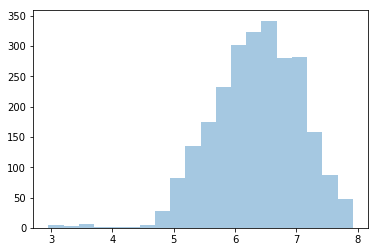

In [48]:
# Create histogram of predictions (this is the log(pred + 1))
seaborn.distplot(prediction_test, kde= False, bins = 20)

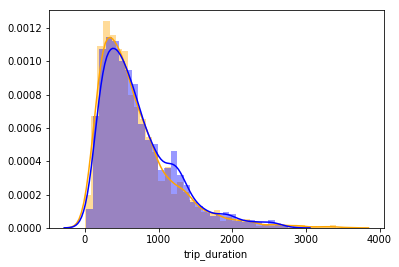

In [49]:
#to retrieve the actual prediction we get the original value
actual_predictions = np.exp(prediction_test) - 1
actual_true_values = np.exp(y_test) - 1
seaborn.distplot(actual_true_values, color = "orange")
seaborn.distplot(actual_predictions, color = "blue")

<h1 style="color: red;">QUESTION 4: MODEL PREDICTIONS</h1>

**Analyze the model predictions. Does the output distribution match the one you made earlier in the case study? What other features/strategies could we use to make our model even better, if we had more time?**

The distribution for the predictions look very similar to the distribution of the actual duration of the test taxi trips. Both distributions almost overlap. Also, both look rougly similar to the original distribution of the complete dataset done on the data analysis section.

For a better model performance we could use hyperparameter tuning on the algorithm. We currently are training the GradientBoostingRegressor with the default parameter values but we could use grid search to find the combination that works better for our data. 

# Feature Importance

In [50]:
# Compute feature importance of model
# You can use the feature_importances function we defined for you
# Or, see the feature_importances_ attribute of our model
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

feature_importances(model, feature_matrix.columns, n=25)

1: Feature: trip_distance, 0.860
2: Feature: HOUR(pickup_datetime), 0.028
3: Feature: dropoff_neighborhoods.longitude, 0.027
4: Feature: dropoff_neighborhoods.latitude, 0.021
5: Feature: HOUR(dropoff_datetime), 0.012
6: Feature: MINUTE(dropoff_datetime), 0.008
7: Feature: MINUTE(pickup_datetime), 0.006
8: Feature: pickup_neighborhoods.latitude, 0.003
9: Feature: pickup_neighborhoods.longitude, 0.003
10: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.003
11: Feature: pickup_neighborhoods.COUNT(trips), 0.003
12: Feature: dropoff_neighborhoods.COUNT(trips), 0.003
13: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
14: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
15: Feature: dropoff_neighborhoods.SUM(trips.passenger_count), 0.001
16: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.001
17: Feature: pickup_neighborhoods.STD(trips.trip_distance), 0.001
18: Feature: payment_type, 0.001
19: Feature: pickup_neighborhoods.MEAN(trips.passen

<h1 style="color: black;">QUESTION 5: FEATURE IMPORTANCE</h1>

**Analyze the feature importance values you just computed above. Do they make sense? Are there any values you are surprised by? Give some brief explanations as to why these features are relevant in computing the `trip_duration` target variable.**

The most relevant feature with the highest importance is the trip_distance. This is completely logical because if the pickup and dropoff points are more distant, we expect it would take longer to get there, unless there is some highway in between the two spots were a longer distance may not necessarilly mean more time. Compared to the other variables, this is the crucial one. The model predictions should be decent even if we take out the rest of the variables and only predict with the distance between pickup and dropoff points.

The next relevant features are related to the hour when the trip took place and the dropoff coordinates. Both of them also make sense since rush hours tend to increase trip duration because of demand and the dropoff point of the trip may be capturing some hot zones in Manhattan where traffic is heavier.

Other features like the average trip distance to a particular neighborhood or the number of passengers seem to be irrelevant for the model according to their feature importance and maybe it would be a nice idea to exclude them from the analysis because they may be making our model worse instead of helping it to get better results. After all, why should a travel duration change if there is only one passenger versus two or more?

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2018+type@asset+block@6.1_instruction_manual.html) to wrap up this case study properly.